In [49]:
from enum import Enum
import random
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import copy
import json
import pandas as pd
import csv
from abc import ABC, abstractmethod
from collections import deque

In [50]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Parent class of all Enums
class Flags(Enum):
    def __eq__(self, other):
        if isinstance(other, Flags):
            return self.value == other.value
        return self.value == other

# Represent Cell Types
class Cell(Flags):
    BLOCKED = 0
    OPEN = 1
    PATH = 2
    LEAK = 3

# Represent Belief Updates
class Belief(Flags):
    NO_LEAK = 0
    NO_BEEP = 1
    BEEP = 2


## The Ship
The layout of the ship (walls, hallways, etc) is on a square grid, generated in the following way:

• Start with a square grid, D × D, of ‘blocked’ cells. Define the neighbors of cell as the adjacent cells in the
up/down/left/right direction. Diagonal cells are not considered neighbors.

• Choose a square in the interior to ‘open’ at random.

• Iteratively do the following:

– Identify all currently blocked cells that have exactly one open neighbor.

– Of these currently blocked cells with exactly one open neighbor, pick one at random.

– Open the selected cell.

– Repeat until you can no longer do so.

• Identify all cells that are ‘dead ends’ - open cells with one open neighbor.

• For approximately half these cells, pick one of their closed neighbors at random and open it.


In [51]:
# Represents the Ship
class Ship:
    def __init__(self, seed = None, leaks = 1, D = 50):
        self.actions = {}
        self.D = D
        self.leaks = leaks
        self.seed = seed
        self.board = []
        self.open_cells = []
        self.initial_leaks = []
        
        self.init_board()
        self.init_leaks()

    
    def init_board(self):
        """Initialize the 50x50 board following Project 1 Algorithm"""
        n = self.D
        random.seed(self.seed)
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # Open approximately half of the dead ends
        num_dead_ends = len(dead_ends)
        while len(dead_ends) > num_dead_ends // 2:

            # Pick a random dead end and open one of it's neighbors
            rand_idx = random.randint(0, len(dead_ends) - 1)
            r, c = dead_ends[rand_idx]
            closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
            if closed_neighbors:
                rand_cell = random.choice(closed_neighbors)
                nr, nc = rand_cell
                self.board[nr][nc] = Cell.OPEN
                open_cells.append((nr, nc))
                dead_ends.pop(rand_idx)

                # Check for newly opened dead ends
                open_neighbors = self.get_neighbors(nr, nc, Cell.OPEN)
                for neighbor in open_neighbors:
                    r, c = neighbor

                    # If this pair is also a dead end, remove it
                    try:
                        idx = dead_ends.index((r, c))
                        dead_ends.pop(idx)
                    except ValueError: # was not a dead end
                        continue
                        
        self.open_cells = open_cells

    def init_leaks(self):
        """Randomly selects a cell to be the leak"""
        for i in range(self.leaks):
            open_cell = random.choice(self.open_cells) # Choose a random cell from the open cells
            r, c = open_cell
    
            self.board[r][c] = Cell.LEAK
            self.open_cells.remove(open_cell)
            self.initial_leaks.append((r, c))
        
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D

    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates

    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        n = self.D
        copy_board = [row[:] for row in self.board]
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 3
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
        

## The Bots
The bot occupies an open cell somewhere in the ship (to be determined shortly). The bot can move to one adjacent cell
every time step (up/down/left/right). Each bot will have access to a different kind of sensor data to help determine
where the atmosphere leak in the ship is - the purpose of the bot is to utilize the available sensor information to
locate and reach the atmosphere leak as quickly as possible. The bot will start at a randomly selected open square
in the ship. The bot knows / can sense when it enters the cell where the leak is located.

##### At each timestep - the bot must choose whether to move or to sense.

In [52]:
# Putting this here because I think it could be an efficient architecture, basically skeleton code
class Bot(ABC):
    def __init__(self, ship):
        self.ship = ship
        self.timestep = 0
        self.path = []
        self.init_bot()
    
    @abstractmethod
    def action(self):
        raise NotImplementedError()

    @abstractmethod
    def move(self):
        raise NotImplementedError()

    @abstractmethod
    def sense(self):
        raise NotImplementedError()

    def init_bot(self):
        """Place bot in random location on the board"""
        r, c = random.choice(self.ship.open_cells)
        self.position = (r, c)
        self.ship.board[r][c] = Cell.PATH
    
    # Helper Methods
    def manhattan(self, curr, goal):
        """Compute manhattan distance between two cells"""
        r, c = curr
        goal_r, goal_c = goal
        return abs(goal_r - r) + abs(goal_c - c)

    def bfs(self, src, goal):
        """Shortest Path from SRC to GOAL -> Returns GOAL, PATH"""

        # Add support for multiple goal states
        if isinstance(goal, tuple):
            state = goal
            goal = set()
            goal.add(state)
        
        queue = deque()
        queue.append((src, deque()))
        vis = set()
        while queue: 
            curr, path = queue.popleft()
            new_path = path.copy()
            new_path.append(curr)
            vis.add(curr)

            if curr in goal:
                return (curr, new_path)
              
            r, c = curr
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.ship.is_valid(nr, nc) and (nr, nc) not in vis and self.ship.board[nr][nc] != Cell.BLOCKED:
                    queue.append(((nr, nc), new_path))   
                    
        return (None, deque())

### Bot 1: 

All cells outside the initial detection square start with the possibility of containing the leak
(essentially, the bot starts having taken a sense action, and detected nothing). When the bot enters
a cell (or starts in a cell), however, if it is not the leak cell, it is marked as not containing the leak. If the
bot detects no leak in proximity - all cells in the detection square are marked as not containing the leak. If
the bot detects a leak in proximity - all cells in the detection square not already marked as not containing the
leak are marked as possibly containing the leak, and all cells outside the detection square are marked as not
containing the leak. Note that if a single square remains that is marked as containing the leak and all others
do not contain the leak - the leak must be in that one marked cell. Bot 1 acts in the following way:

– At any time that has not detected a leak, it will proceed to the nearest cell that might contain the leak
(breaking ties at random), enter it, and take the sense action, updating what it knows based on the results.

– At any time that a leak has been detected, it will proceed to the nearest cell that might contain the leak,
enter it, and in doing so either find the leak or rule that cell out.

This proceeds until the leak is discovered.

In [53]:
class BotOne(Bot):    
    def __init__(self, ship, k = 1):
        Bot.__init__(self, ship)

        self.k = k
        self.unseen = set(ship.open_cells)
        self.not_leaky = set() 
        self.leaky = set() 
        self.future_path = deque()       
                
    def action(self):
        """Choose to move or sense"""
        pos = self.position
        r, c = pos
        
        if self.ship.board[r][c] == Cell.LEAK:
            return True
        elif pos in self.leaky:
            self.not_leaky.add(pos)
            self.leaky.remove(pos)

        if self.leaky:
            self.move()
        else:
            if pos in self.not_leaky:
                self.move()
            else:
                self.sense(self.k)               
                
        return False

    def move(self):
        """Update self.position and cell enum to mark path"""
        curr = self.position
        r, c = curr
        self.path.append(curr)
        self.ship.board[r][c] = Cell.PATH
        
        if not self.future_path:        
            self.future_path = self.bfs(curr, self.leaky if self.leaky else self.unseen)[1]

        # Update path to next point in path
        next_position = self.future_path.popleft()
        nr, nc = next_position
        self.position = next_position
        
    def sense(self, k = 1):
        """Sense if leak is within (2k + 1)^2 square"""
        detection_square = []
        r, c = self.position

        leakExists = False
        
        for row in range(r - k, r + k + 1):
            for col in range (c - k, c + k + 1):
                if self.ship.is_valid(row, col) and self.ship.board[row][col] != Cell.BLOCKED:
                    loc = (row, col)
                    detection_square.append(loc)

                    if self.ship.board[row][col] == Cell.LEAK:
                        leakExists = True 

        if not leakExists:
            # If detection square isn't leaky, add all cells to not_leaky set and remove any that may exist in leaky set
            for cell in detection_square:
                self.not_leaky.add(cell)
                if cell in self.unseen:
                    self.unseen.remove(cell)
                if cell in self.leaky:
                    self.leaky.remove(cell)
        else:
            # If detection square is leaky, add all squares that aren't already checked into leaky set
            for cell in detection_square:
                if cell not in self.not_leaky:
                    self.leaky.add(cell)
                if cell in self.unseen:
                    self.unseen.remove(cell)

        self.temp = detection_square
            
        return leakExists

    def simulate(self):
        success = False

        while not success:# and self.timestep < 5000:
            #print(self.future_path)
            res = self.action()
            if res:
                success = True

            self.timestep += 1

        return success, self.path, self.timestep

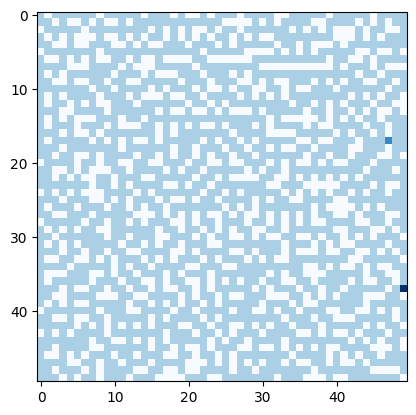

Bot position: (17, 47)
Leak position: [(37, 49)]


In [8]:
ship = Ship(3255)
bot = BotOne(ship, 2)

ship.display()
print("Bot position: %s" % (bot.position,))
print("Leak position: %s" % (ship.initial_leaks,))

True 1645 steps


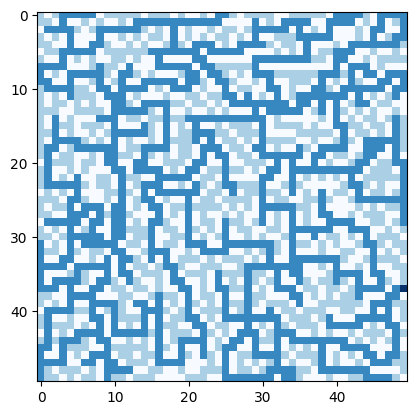

In [9]:
res = bot.simulate()
print(str(res[0]) + " " + str(res[2]) + " steps")
ship.display()

In [ ]:
print("100 tests:")
sum = 0

for seed in np.random.randint(low=0, high=1000000000, size=100):
    seed = int(seed)
    ship = Ship(seed)
    bot = BotOne(ship, 2)
    res = bot.simulate()
    sum += res[2]
    print(str(seed) + ": " + str(res[0]) + " " + str(res[2]) + " steps")

avg = sum / 100
print("\naverage: " + str(avg) + " steps")

### Bot 3: 

All cells (other than the bot’s initial cell) start with equal probability of containing the leak. Bot 3
proceeds in the following well:

– At any time, the bot is going to move to the cell that has the highest probability of containing the leak
(breaking ties first by distance from the bot, then at random).

– After entering any cell, if the cell does not contain a leak, the bot will take the sense action. Based on
the results, it updates the probability of containing the leak for each cell∗.

– After the beliefs are updated, this repeats, the bot proceeding to the cell that as the highest probability
of containing the leak (breaking ties first by distance from the bot, then at random)

In [64]:
class BotThree(Bot):
    def __init__(self, ship, alpha):
        super().__init__(ship)
        self.alpha = alpha
        self.prob_matrix, self.leaky = self.init_prob_matrix()
        self.distances = self.init_distances()   

    def action(self):
        pass

    def move(self):
        """Move to the cell with the highest probability (of least distance)"""
        dst, path = self.find_highest_prob()
        self.position = dst
        return path
        
    def sense(self):
        """Determine whether or not beep was heard from current position"""
        r, c = self.position
        dist_from_leak = self.distances[r][c]
        beep_prob = self.get_beep_prob(dist_from_leak)
        return random.uniform(0, 1) <= beep_prob

    def simulate(self):
        """                
            Case 2: Heard beep in current cell
                Probability to find: P(a | beep in curr) for all a
                
            Case 3: Didn't hear beep in current cell
                Probability to find: P(a | ~beep in curr) for all a
        """
        success = False
        while not success:
            path_taken = self.move()
            self.path += path_taken
            curr_position = self.position
            r, c = curr_position
            
            if self.ship.board[r][c] == Cell.LEAK:
                success = True
            else:
                
                # Remove this from potential leaky cells, update probabilities
                self.leaky.remove((r, c))
                self.update_no_leak()

                # Sense for beep, update probabilities
                heard_beep = self.sense()
                self.update_based_on_beep(heard_beep)
                
                self.timestep += 2 

        return success, self.path, self.timestep   
        
    # THESE TWO FUNCTIONS WILL LIKELY NEED TO GO INTO GENERAL BOT CLASS
    def init_prob_matrix(self):
        """Initialize Probability Matrix, originally giving all OPEN CELLS equal chance of having the leak"""
        board = self.ship.board
        n = len(board)
        num_open_cells = len(self.ship.open_cells)
        default_prob = (1 / num_open_cells)
        prob_matrix = [[0 for _ in range(n)] for _ in range(n)]
        leaky = set()
        for i in range(n):
            for j in range(n):
                if board[i][j] != Cell.BLOCKED:
                    prob_matrix[i][j] = default_prob
                    leaky.add((i, j))    

        return prob_matrix, leaky

    def init_distances(self):
        """Calculate distance from the leak to every other cell in the board"""
        n = len(self.ship.board)
        distances = [[0 for _ in range(n)] for _ in range(n)]
        leak_location = self.ship.initial_leaks[0]
        
        queue = deque()
        queue.append((leak_location, 0))
        
        vis = set()
        while queue: 
            curr, dist = queue.popleft()
            r, c = curr
            distances[r][c] = dist
            vis.add(curr)

            dist += 1
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.ship.is_valid(nr, nc) and (nr, nc) not in vis and self.ship.board[nr][nc] != Cell.BLOCKED:
                    queue.append(((nr, nc), dist))

        return distances

    def get_beep_prob(self, dist_from_leak):
        """Calculate probability of hearing a beep given distance from leak"""
        return np.e ** ( (-self.alpha) * (dist_from_leak - 1) )

    def update_no_leak(self):
        """Update prior beliefs based on entering a cell with no leak"""
        n = len(self.ship.board)
        current_matrix = self.prob_matrix
        result_matrix = [[0 for _ in range(n)] for _ in range(n)]
        r, c = self.position

        not_curr = 1 - current_matrix[r][c] 
        for i in range(n):
            for j in range(n):
                result_matrix[i][j] = current_matrix[i][j] / not_curr              
        result_matrix[r][c] = 0

        self.prob_matrix = result_matrix
        

    def update_based_on_beep(self, heard_beep):
        """Update prior beliefs based on hearing or not hearing a beep at a given cell"""
        n = len(self.ship.board)
        current_matrix = self.prob_matrix
        result_matrix = [[0 for _ in range(n)] for _ in range(n)]
        r, c = self.position
        dist_from_leak = self.distances[r][c]
        beep_prob = self.get_beep_prob(dist_from_leak)

        for i in range(n):
            for j in range(n):
                if not heard_beep:
                    result_matrix[i][j] = current
        self.prob_matrix = result_matrix

    def find_highest_prob(self):
        """Get the cell with the current highest chance of containing the leak"""
        max_prob = -np.inf
        min_dist = np.inf
        candidates = set() 

        # Iterate over every potentially leaky cell, find cell(s) with best chance
        for r, c in self.leaky:
            curr_prob = self.prob_matrix[r][c]
            curr_dist = self.distances[r][c]

            # New Best Found
            if curr_prob > max_prob:
                max_prob = curr_prob
                min_dist = curr_dist
                candidates = set((r, c))

            # Add to candidate set
            elif curr_prob == max_prob:
                candidates.add((r, c))

        # Break tie, find (and navigate to) cell of highest probability and least dstance
        best_cell, path = self.bfs(self.position, candidates)
        return best_cell, path 


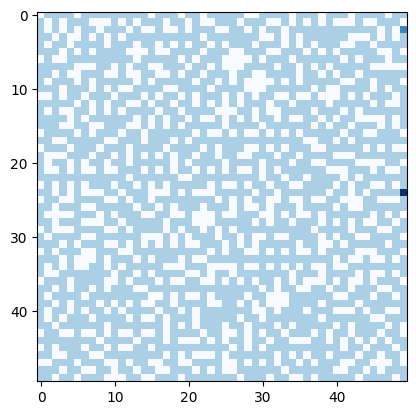

In [73]:
ship = Ship()
bot = BotThree(ship, 5)
ship.display()
